# Gemma 3N Streaming Inference - Version 1: ProAssist-Style

This notebook implements streaming inference using Gemma 3N model that mimics the behavior of ProAssist model's streaming inference. The model is forced to generate something at each assistant turn from the dataset sample, similar to the original ProAssist implementation.

Key features:
- Uses Gemma 3N model instead of ProAssist
- External context management with summarization when context limit is reached
- Prints processed contexts and compares generated vs reference responses

## Setup and Model Loading

In [1]:
%%capture
!pip install torch torchvision Pillow transformers==4.55.4 datasets matplotlib peft accelerate unsloth
!pip install --no-deps --upgrade timm 

In [2]:
import torch; torch._dynamo.config.recompile_limit = 64;
import json
from dataclasses import dataclass, asdict
from PIL import Image
from transformers import AutoProcessor, Gemma3nForConditionalGeneration
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import numpy as np
from typing import List, Dict, Any, Optional, Tuple
import pprint

# Import ProAssist components for dataset loading
from mmassist.model import build_from_checkpoint
from mmassist.configs.arguments import EvalArguments
from mmassist.eval.eval_utils import parse_inference_setups
from mmassist.data import build_train_dataset, build_eval_datasets
from mmassist.configs.arguments import DATA_ROOT_DIR
from mmassist.data.utils import tensor_to_pil_images

/u/swong2/.conda/envs/gemma3n/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# # Load Gemma 3N model
# model_id = "google/gemma-3n-e4b-it"

# print("Loading Gemma 3N model...")
# gemma_model = Gemma3nForConditionalGeneration.from_pretrained(
#     model_id, 
#     device_map="auto", 
#     dtype=torch.bfloat16
# ).eval()

# gemma_processor = AutoProcessor.from_pretrained(model_id)

# print(f"Model loaded on device: {gemma_model.device}")
# print(f"Model dtype: {gemma_model.dtype}")

In [4]:
from unsloth import FastModel

gemma_model, gemma_processor = FastModel.from_pretrained(
    model_name = "unsloth/gemma-3n-E4B-it",
    dtype = None, # None for auto detection
    max_seq_length = 1024, # Choose any for long context!
    load_in_4bit = False,  # 4 bit quantization to reduce memory
    full_finetuning = False, # [NEW!] We have full finetuning now!
    # token = "hf_...", # use one if using gated models
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.8.10: Fast Gemma3N patching. Transformers: 4.55.4.
   \\   /|    NVIDIA A40. Num GPUs = 1. Max memory: 44.339 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.6. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Gemma3N does not support SDPA - switching to fast eager.
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


Loading checkpoint shards: 100%|██████████| 4/4 [00:27<00:00,  6.76s/it]


In [5]:
from transformers import TextStreamer
# Helper function for inference
def do_gemma_3n_inference(messages, max_new_tokens = 128):
    res = unsloth_model.generate(
        **unsloth_tokenizer.apply_chat_template(
            messages,
            add_generation_prompt = True, # Must add for generation
            tokenize = True,
            return_dict = True,
            return_tensors = "pt",
        ).to("cuda"),
        max_new_tokens = max_new_tokens,
        temperature = 1.0, top_p = 0.95, top_k = 64,
        streamer = TextStreamer(unsloth_tokenizer, skip_prompt = True),
    )
    return res

## Load ProAssist Dataset

In [6]:
# Load the same dataset used in ProAssist streaming inference
inference_setups = "wtag/dialog-klg_val_L0_I1|stream|4k|0.5|summarize_and_drop"
eval_args = EvalArguments(model_path="dummy", inference_setups=inference_setups)

# Build dataset configuration
class DummyConfig:
    def __init__(self):
        self.data_root_dir = f"{DATA_ROOT_DIR}/processed_data"
        self.training_args = {
            "data_root_dir": f"{DATA_ROOT_DIR}/processed_data",
            "eval_datasets": inference_setups.split("|")[0]
        }
    
    def to_dict(self):
        return {
            "data_root_dir": self.data_root_dir,
            **self.training_args
        }

config = DummyConfig()
all_args_dict = config.to_dict()

print("Loading dataset...")
dataset_dict = build_eval_datasets(**all_args_dict, print_info=True, keep_images=True)
datasets = list(dataset_dict.values())
dataset = datasets[0]

print(f"Dataset loaded with {len(dataset)} samples")

Loading dataset...
Evaluation datasets:
* wtag/dialog-klg_val | num samples: 21

Dataset loaded with 21 samples


In [7]:
dataset[0]

{'dataset': 'wtag/dialog-klg_val_L0_I1',
 'sample_idx': 0,
 'video_uid': 'T48',
 'conversation': [{'role': 'system',
   'content': "You are a proactive assistant. Predict the user's needs and provide assistance before being requested.",
   'start': None,
   'end': None,
   'time': None,
   'labels': None,
   'progress': None},
  {'role': 'frames',
   'content': None,
   'start': 0,
   'end': 8,
   'time': None,
   'labels': None,
   'progress': None},
  {'role': 'user',
   'content': 'I want to make pour-over coffee.',
   'start': None,
   'end': None,
   'time': 4.1,
   'labels': '',
   'progress': None},
  {'role': 'system',
   'content': 'Task knowledge: Pour-over Coffee\n\nIngredients\n12 oz water\n25 grams whole coffee beans\n\nTools and Utensils\n2-cup liquid measuring cup electric kettle\nkitchen scale\ncoffee grinder\nfilter cone dripper (stainless steel)\npaper basket filter (standard 8-12 cup size) 12-ounce coffee mug\nthermometer\ntimer (optional)\n\nSteps\n1. Measure 12 oun

## Gemma 3N Stream Processor and Runner

In [8]:
@dataclass
class Gemma3NFrameInput:
    """Enhanced input unit for context-aware Gemma 3N streaming inference."""
    current_image: Image.Image  # Current frame image
    frame_idx_in_stream: int
    frame_idx_in_original_video: int
    timestamp: float
    ref_output_str: Optional[str] = None
    accumulated_user_messages: List[str] = None  # User message(s) right before this frame

@dataclass
class Gemma3NFrameOutput:
    """Enhanced per-frame output from Gemma 3N streaming inference."""
    gen: str
    ref: Optional[str] = None
    current_image: Optional[Image.Image] = None
    frame_idx_in_stream: Optional[int] = None
    frame_idx_in_original_video: Optional[int] = None
    timestamp_in_stream: Optional[float] = None
    context_length: Optional[int] = None

    def to_dict(self, ignore_keys: str | list[str] = "current_image") -> dict:
        ret = asdict(self)
        if ignore_keys:
            if isinstance(ignore_keys, str):
                ignore_keys = [ignore_keys]
            for k in ignore_keys:
                ret.pop(k, None)
        return ret

In [9]:
class Gemma3NStreamProcessor:
    """Enhanced processor for context-aware Gemma 3N streaming inference."""
    
    def __init__(self, processor, fps: int = 2):
        self.processor = processor
        self.fps = fps
    
    def combine_system_messages(self, conversation: List[Dict]) -> str:
        """Combine all system messages into one comprehensive system message."""
        system_messages = []
        for turn in conversation:
            if turn["role"] == "system":
                system_messages.append(turn["content"])
        
        if not system_messages:
            return ""
        
        # Combine with double newlines for clarity
        return "\n\n".join(system_messages)
    
    def processed_conv_data_to_stream(self, video: Dict) -> Tuple[List[Gemma3NFrameInput], str]:
        """Convert ProAssist video data to enhanced stream format with proper conversation flow."""
        conversation = video["conversation"]
        frame_index_offset = video["start_frame_idx"]
        images = video.get("images", None)
        
        if images is None:
            raise ValueError("Images are required for Gemma 3N streaming inference")
        
        # Step 1: Combine all system messages
        combined_system_prompt = self.combine_system_messages(conversation)
        
        # Step 2: Process conversation sequentially
        frame_streams = []
        accumulated_user_messages = []  # Messages accumulated so far
        
        for turn_idx, turn in enumerate(conversation):
            if turn["role"] == "user":
                # Add user message to accumulated context
                accumulated_user_messages.append(turn["content"])
                
            elif turn["role"] == "frames":
                # Process frames in this segment
                start = turn["start"] - frame_index_offset
                end = turn["end"] - frame_index_offset
                
                # Get reference output for the last frame in this segment
                ref_output_str = None
                if turn_idx < len(conversation) - 1:
                    next_turn = conversation[turn_idx + 1]
                    if next_turn["role"] == "assistant":
                        ref_output_str = next_turn["content"]
                
                for k in range(start, end):
                    # Convert image tensor to PIL
                    pt_img = images[k : k + 1]
                    pil_img = tensor_to_pil_images(pt_img)[0]
                    
                    # Create frame input (messages will be built later with full context)
                    time = (len(frame_streams) + 1) / self.fps
                    
                    # Reference output only for the last frame in segment
                    frame_ref = ref_output_str if k == end - 1 else None
                    
                    frame = Gemma3NFrameInput(
                        current_image=pil_img,
                        frame_idx_in_stream=len(frame_streams),
                        frame_idx_in_original_video=k + frame_index_offset,
                        timestamp=time,
                        ref_output_str=frame_ref,
                        accumulated_user_messages=accumulated_user_messages
                    )
                    
                    frame_streams.append(frame)

                    # Only the first frame in the segment gets the new user messages, so reset
                    accumulated_user_messages = []
        
        return frame_streams, combined_system_prompt

In [10]:
class Gemma3NStreamRunner:
    """Enhanced streaming inference runner with full context awareness."""
    
    def __init__(self, model, processor, fps: int = 2, max_context_tokens: int = 30000):
        self.model = model
        self.processor = processor
        self.fps = fps
        self.max_context_tokens = max_context_tokens
        self.stream_processor = Gemma3NStreamProcessor(processor, fps)
        
        # Enhanced context management
        self.conversation_history = []  # List of message dicts
        self.frame_history = []  # List of images
        self.tokens_per_image = 256  # As specified
        
        # Summary agent system message
        self.summary_agent_prompt = """You are a conversation summarization agent. Your task is to provide a concise but comprehensive summary of the conversation history below, focusing on:
1. Key events and actions that occurred
2. Important decisions made
3. Visual observations from images
4. Context needed to continue the conversation naturally
5. Any ongoing tasks or objectives

Provide a clear, structured summary that maintains the essential information for continuing the conversation."""
    
    def count_tokens_with_images(self) -> int:
        """Count tokens including both text and images in conversation_history"""
        total_tokens = 0
        
        for turn in self.conversation_history:
            for message in turn["content"]:
                if message["type"] == "text":
                    total_tokens += len(self.processor.tokenizer(message["text"])["input_ids"])
                else: # message["type"] == "image":
                    total_tokens += self.tokens_per_image
        
        return total_tokens
    
    def manage_context(self) -> bool:
        """Manage context size and return True if summarization occurred."""
        # Count current tokens
        current_tokens = self.count_tokens_with_images()
        
        if current_tokens > self.max_context_tokens:
            print(f"\n[CONTEXT MANAGEMENT] Token limit reached ({current_tokens} > {self.max_context_tokens}). Generating summary...")
            
            # Replace first message of first user turn with summary agent prompt
            old_first_user_msg = self.conversation_history[0]["content"][0]["text"]
            self.conversation_history[0]["content"][0]["text"] = self.summary_agent_prompt
            
            # Generate summary
            summary = self.generate_response(self.conversation_history)
            print(f"[CONTEXT MANAGEMENT] Generated summary: {summary[:200]}...")
            
            # Create new first_user_msg (system message) with new summary
            if "Previous context summary:" not in old_first_user_msg:
                old_first_user_msg += "\n\nPrevious context summary: "
            new_first_user_msg = old_first_user_msg + summary


            
            # Replace conversation history with new system message (uses user role)
            self.conversation_history = [
                {
                    "role": "user",
                    "content": [{"type": "text", "text": new_first_user_msg}],
                }
            ]
            
            new_tokens = self.count_tokens_with_images()
            print(f"[CONTEXT MANAGEMENT] Context reset. New token count: {new_tokens}")
            
            return True
        
        return False
    
    def generate_response(self, messages: List[Dict[str, Any]]) -> str:
        """Generate response using Gemma 3N model."""
        inputs = self.processor.apply_chat_template(
            messages,
            add_generation_prompt=True,
            tokenize=True,
            return_dict=True,
            return_tensors="pt"
        ).to(self.model.device)
        
        with torch.inference_mode():
            generation = self.model.generate(
                **inputs,
                max_new_tokens=256,
                do_sample=True,
                temperature=1.0,
                top_p=0.95,
                top_k=64
            )
        
        input_len = inputs["input_ids"].shape[-1]
        response = self.processor.decode(generation[0][input_len:], skip_special_tokens=True)
        return response.strip()
    
    def run_inference_on_video(self, 
                             video: Dict, 
                             verbose: bool = False,
                             max_time: int = -1) -> Dict:
        """Run enhanced context-aware streaming inference on a video."""
        
        if verbose:
            print("Preprocessing stream data...")
        
        # Get frame streams and system prompt
        streams, combined_system_prompt = self.stream_processor.processed_conv_data_to_stream(video)

        # Initialize context
        self.conversation_history.append(
            {
                "role": "user",
                "content": [{"type": "text", "text": combined_system_prompt}],
            }
        )
        
        outputs = []
        
        for frame_input in streams:

            # add accumulated_user_messages to conversation history
            accumulated_user_messages_str = "\n".join(frame_input.accumulated_user_messages)
            if frame_input.accumulated_user_messages:
                if self.conversation_history[-1]["role"] == "user":
                    self.conversation_history[-1]["content"].append(
                        {"type": "text", "text": accumulated_user_messages_str}
                    )
                
                else: # lastest message is assistant
                    self.conversation_history.append(
                        {
                            "role": "user",
                            "content": [{"type": "text", "text": accumulated_user_messages_str}],
                        }
                    )

            # add current frame image to conversation history
            if self.conversation_history[-1]["role"] == "user":
                self.conversation_history[-1]["content"].append(
                    {"type": "image", "image": frame_input.current_image}
                )
            
            else: # lastest message is assistant
                self.conversation_history.append(
                    {
                        "role": "user",
                        "content": [{"type": "image", "image": frame_input.current_image}],
                    }
                )
            
            # Manage context size
            summarized = self.manage_context()
            
            # Generate response
            generated_response = self.generate_response(self.conversation_history)

            self.conversation_history.append(
                {
                    "role": "assistant",
                    "content": [{"type": "text", "text": generated_response}],
                }
            )
            
            # Create output
            output = Gemma3NFrameOutput(
                gen=generated_response,
                ref=frame_input.ref_output_str,
                current_image=frame_input.current_image,
                frame_idx_in_stream=frame_input.frame_idx_in_stream,
                frame_idx_in_original_video=frame_input.frame_idx_in_original_video,
                timestamp_in_stream=frame_input.timestamp,
                context_length=self.count_tokens_with_images(),
            )
            
            outputs.append(output)
            
            # Verbose output
            if verbose:
                print(f"\n=== Frame {frame_input.frame_idx_in_stream} ({frame_input.timestamp:.1f}s) ===")
                if frame_input.accumulated_user_messages:
                    for msg in frame_input.accumulated_user_messages:
                        print(f"[{frame_input.timestamp:.1f}s] USER: {msg}")
                print(f"[{frame_input.timestamp:.1f}s] REF : {frame_input.ref_output_str}")
                print(f"[{frame_input.timestamp:.1f}s] GEN : {generated_response}")

            # Check max time limit
            if max_time > 0 and frame_input.timestamp >= max_time:
                if verbose:
                    print(f"\nMax time reached: {max_time}s")
                break
        
        metadata = {
            "dataset": video.get("dataset", "unknown"),
            "sample_idx": video.get("sample_idx", -1),
            "video_uid": video.get("video_uid", "unknown"),
            "fps": self.fps,
            "model_type": "gemma-3n-e4b-it",
            "max_context_tokens": self.max_context_tokens,
            "total_frames_processed": len(outputs)
        }
        
        return {"metadata": metadata, "predictions": outputs}


## Test Model Inference with Image and Text

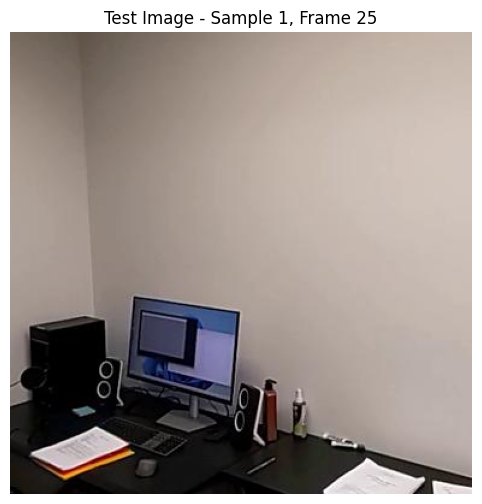

Generating response...

=== MODEL RESPONSE ===
Sample: 1, Frame: 25
Video ID: T48
Response: You


In [15]:


# Select a sample and frame from the dataset
test_sample_idx = 1
test_frame_idx = 5

# Get the sample and extract an image
test_sample = dataset[test_sample_idx]
test_images = test_sample.get('images', [])

if len(test_images) > test_frame_idx:
    # Convert tensor image to PIL (same as streamprocessor)
    pt_img = test_images[test_frame_idx : test_frame_idx + 1]
    pil_img = tensor_to_pil_images(pt_img)[0]

    test_frame_idx += 10
    pt_img = test_images[test_frame_idx : test_frame_idx + 1]
    pil_img2 = tensor_to_pil_images(pt_img)[0]
    
    test_frame_idx += 10
    pt_img = test_images[test_frame_idx : test_frame_idx + 1]
    pil_img3 = tensor_to_pil_images(pt_img)[0]

    # Display the image
    plt.figure(figsize=(8, 6))
    plt.imshow(pil_img)
    plt.title(f'Test Image - Sample {test_sample_idx}, Frame {test_frame_idx}')
    plt.axis('off')
    plt.show()
    
    # Create message format for Gemma 3N (same format as streamprocessor)
    test_messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "How many images are given below? Compare them. I want short response."},
                {"type": "image", "image": pil_img},
            ]
        },
        {
            "role": "assistant",
            "content": [
                {"type": "text", "text": "there are 100 images"}
            ]
        },
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "was your previous response correct?"},
                {"type": "image", "image": pil_img},
            ]
        },
        {
            "role": "assistant",
            "content": [
                {"type": "text", "text": "there are 100 images"}
            ]
        },
    ]
    
    # Generate response using the same method as the runner
    print("Generating response...")

    # do_gemma_3n_inference(test_messages, max_new_tokens = 30)
    # raise RuntimeError("HELLOWORLD")

    inputs = gemma_processor.apply_chat_template(
        test_messages,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt"
    ).to(gemma_model.device)
    
    with torch.inference_mode():
        generation = gemma_model.generate(
            **inputs,
            max_new_tokens=1,
            do_sample=True,
            temperature=1.0,
            top_p=0.95,
            top_k=64
        )
    
    input_len = inputs["input_ids"].shape[-1]
    response = gemma_processor.decode(generation[0][input_len:], skip_special_tokens=True)
    
    print(f"\n=== MODEL RESPONSE ===")
    print(f"Sample: {test_sample_idx}, Frame: {test_frame_idx}")
    print(f"Video ID: {test_sample.get('video_uid', 'N/A')}")
    print(f"Response: {response.strip()}")
    
else:
    print(f"No images available in sample {test_sample_idx} or frame {test_frame_idx} doesn't exist")
    print(f"Available samples: {len(dataset)}")
    if test_sample_idx < len(dataset):
        print(f"Images in sample {test_sample_idx}: {len(test_sample.get('images', []))}")


## Display Sample Data

=== Sample 3 ===
Video ID: T54
Number of images: 1375

=== Conversation ===
1. [SYSTEM]: You are a proactive assistant. Predict the user's needs and provide assistance before being requested.
2. [FRAMES]: 0 - 13
3. [USER]: I want to make pour-over coffee.
4. [SYSTEM]: Task knowledge: Pour-over Coffee

Ingredients
12 oz water
25 grams whole coffee beans

Tools and Utensils
2-cup liquid measuring cup electric kettle
kitchen scale
coffee grinder
filter cone dripper (stainless steel)
paper basket filter (standard 8-12 cup size) 12-ounce coffee mug
thermometer
timer (optional)

Steps
1. Measure 12 ounces of cold water and transfer to a kettle.
2. While the water is boiling, assemble the filter cone. Place the dripper on top of a coffee mug.
3. Prepare the filter insert by folding the paper filter in half to create a semi-circle, and in half again
to create a quarter-circle. Place the paper filter in the dripper and spread open to create a cone.
4. Weigh the coffee beans and grind until the 

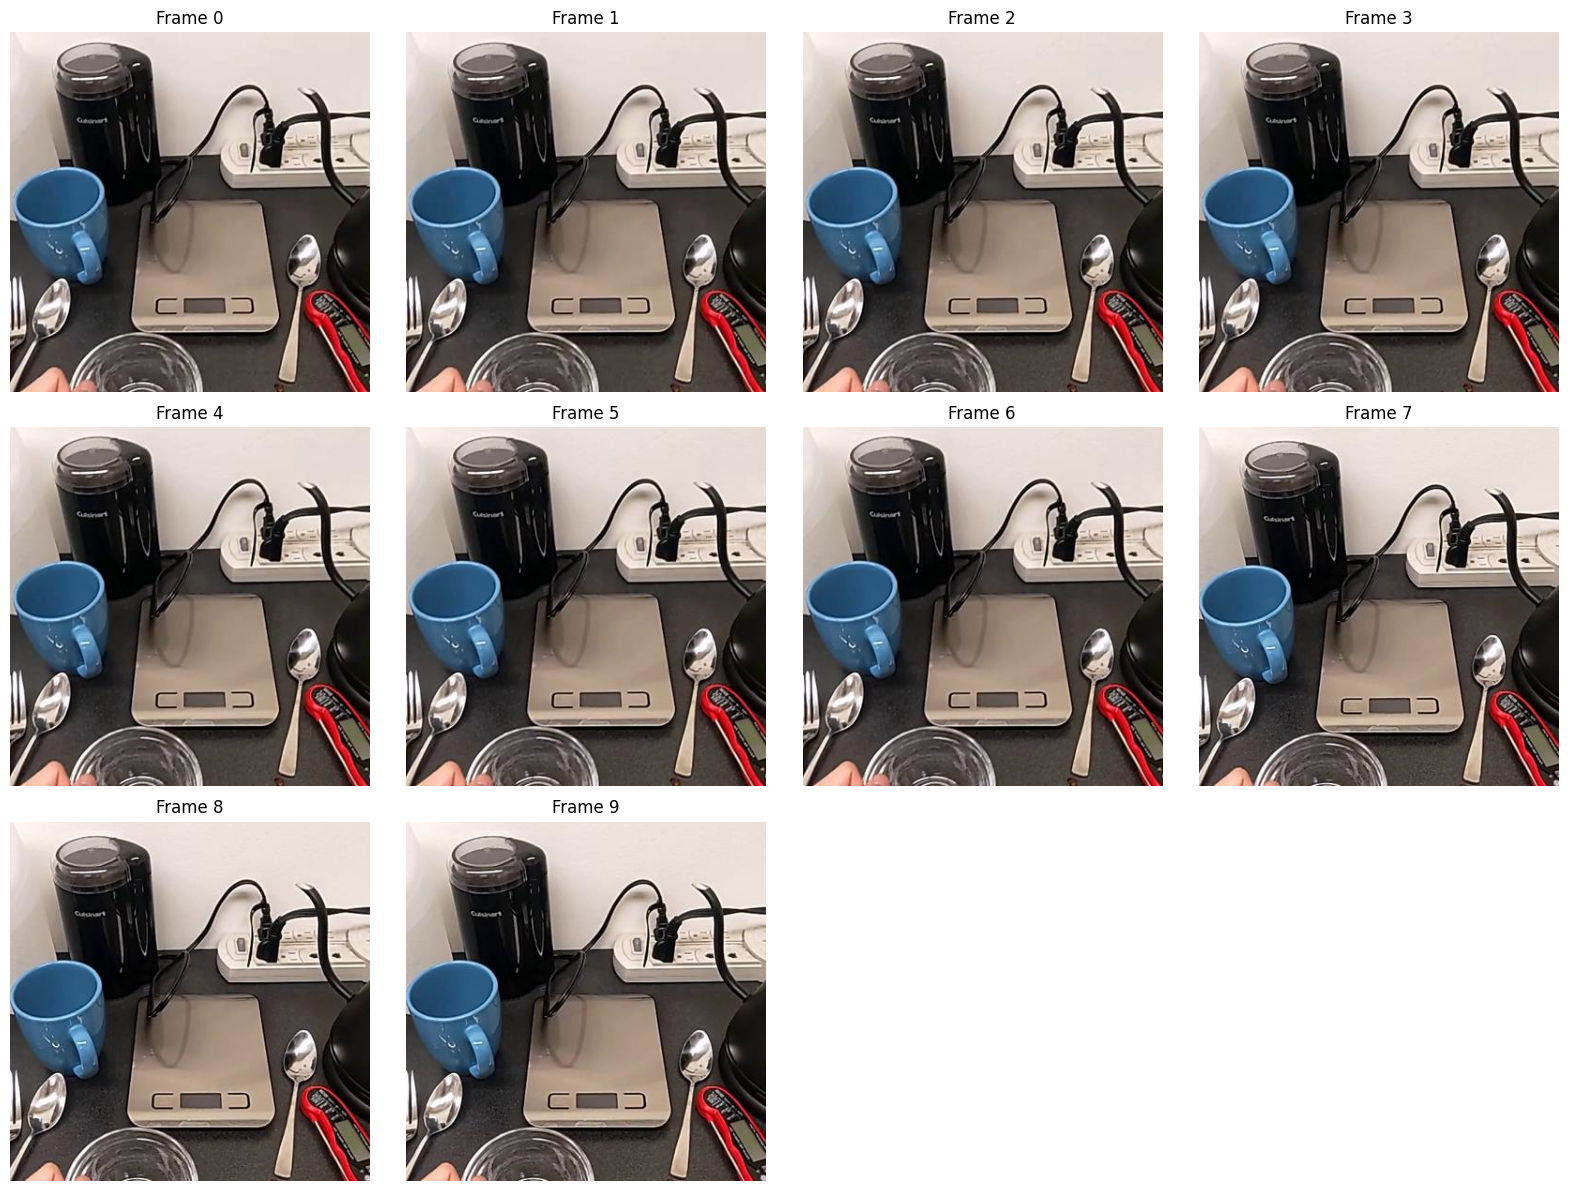

In [12]:
def display_sample_with_frames(dataset, sample_idx=0, max_frames_to_show=10):
    """Display a sample from the dataset with its frames and conversation."""
    
    sample = dataset[sample_idx]
    
    print(f"=== Sample {sample_idx} ===")
    print(f"Video ID: {sample.get('video_uid', 'N/A')}")
    print(f"Number of images: {len(sample.get('images', []))}")
    
    # Display conversation
    if 'conversation' in sample:
        print("\n=== Conversation ===")
        for i, conv in enumerate(sample['conversation']):
            role = conv.get('role', 'unknown')
            if role == "frames":
                content = f"{conv['start']} - {conv['end']}"
            else:
                content = conv.get('content', '')
            print(f"{i+1}. [{role.upper()}]: {content}")
    
    # Display frames
    images = sample.get('images', [])
    if images != []:
        n_display = min(max_frames_to_show, len(images))
        print(f"\n=== Displaying {n_display} frames ===")
        
        cols = 4
        rows = (n_display + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
        if rows == 1:
            axes = axes.reshape(1, -1)
        
        for i in range(n_display):
            row, col = i // cols, i % cols
            ax = axes[row, col]
            
            # Convert image to displayable format
            img = images[i]
            img_norm = (img - img.min()) / (img.max() - img.min())
            img_np = img_norm.permute(1, 2, 0).detach().cpu().numpy()
            
            ax.imshow(img_np)
            ax.set_title(f'Frame {i}')
            ax.axis('off')
        
        # Hide empty subplots
        for i in range(n_display, rows * cols):
            row, col = i // cols, i % cols
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.show()

# Display the first sample
display_sample_with_frames(dataset, sample_idx=3)

## Run Streaming Inference

In [13]:
# Create the streaming runner
runner = Gemma3NStreamRunner(
    model=gemma_model,
    processor=gemma_processor,
    fps=2,
    max_context_tokens=30000
)

print("Gemma 3N Stream Runner initialized")
print(f"Max context tokens: {runner.max_context_tokens}")
print(f"FPS: {runner.fps}")

Gemma 3N Stream Runner initialized
Max context tokens: 30000
FPS: 2


In [14]:
# Run streaming inference on a single video (ProAssist-style)
sample_idx = 3  # Choose a sample to test
video = dataset[sample_idx]

print(f"Running streaming inference on sample {sample_idx}...")
print(f"Video ID: {video.get('video_uid', 'N/A')}")
print(f"Number of frames: {len(video.get('images', []))}")

# Run inference with verbose output
results = runner.run_inference_on_video(
    video,
    verbose=True,
    max_time=60  # Limit to 60 seconds for demo
)

print(f"\n=== INFERENCE COMPLETE ===")
print(f"Total frames processed: {len(results['predictions'])}")
print(f"Metadata: {results['metadata']}")

Running streaming inference on sample 3...
Video ID: T54
Number of frames: 1375
Preprocessing stream data...

=== Frame 0 (0.5s) ===
[0.5s] REF : None
[0.5s] GEN : Okay, I see you're preparing to make pour-over coffee! It looks like you have most of the necessary equipment laid out. 

Based on the image and the task knowledge, here's what I can predict you might need or want:

* **Coffee Beans:** You have a scale, so you likely have your 25 grams of whole coffee beans ready to be ground.
* **Grinder:**  You have a coffee grinder present, which is essential for achieving the coarse sand consistency needed for pour-over.
* **Kettle:** You have a 2-cup electric kettle, which is great for precise water measurement and temperature control.
* **Mug:** You have a 12-ounce mug ready to receive your brewed coffee.
* **Thermometer:** You have a thermometer, which is helpful for ensuring the water temperature is within the optimal range (195-205°F or 91-96°C).
* **Timer (Optional):** While not st

OutOfMemoryError: CUDA out of memory. Tried to allocate 8.05 GiB. GPU 0 has a total capacity of 44.34 GiB of which 5.57 GiB is free. Including non-PyTorch memory, this process has 38.76 GiB memory in use. Of the allocated memory 36.80 GiB is allocated by PyTorch, and 1.62 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Analysis and Comparison

In [ ]:
# Analyze the results
def analyze_streaming_results(results):
    """Analyze and display streaming inference results."""
    predictions = results['predictions']
    metadata = results['metadata']
    
    print(f"=== STREAMING INFERENCE ANALYSIS ===")
    print(f"Model: {metadata['model_type']}")
    print(f"Total frames processed: {metadata['total_frames_processed']}")
    print(f"FPS: {metadata['fps']}")
    print(f"Max context tokens: {metadata['max_context_tokens']}")
    
    # Count frames with responses
    frames_with_responses = sum(1 for p in predictions if p.gen.strip())
    frames_with_references = sum(1 for p in predictions if p.ref and p.ref.strip())
    
    print(f"\nFrames with generated responses: {frames_with_responses}/{len(predictions)}")
    print(f"Frames with reference responses: {frames_with_references}/{len(predictions)}")
    
    # Show context length progression
    context_lengths = [p.context_length for p in predictions if p.context_length]
    if context_lengths:
        print(f"\nContext length progression:")
        print(f"  Initial: {context_lengths[0]}")
        print(f"  Final: {context_lengths[-1]}")
        print(f"  Max: {max(context_lengths)}")
    
    # Show some example comparisons
    print(f"\n=== EXAMPLE COMPARISONS ===")
    comparison_count = 0
    for i, pred in enumerate(predictions):
        if pred.ref and pred.ref.strip() and comparison_count < 3:
            print(f"\nFrame {pred.frame_idx_in_stream} ({pred.timestamp_in_stream:.1f}s):")
            print(f"  REF: {pred.ref}")
            print(f"  GEN: {pred.gen}")
            comparison_count += 1

# Analyze the results
analyze_streaming_results(results)

## Test Multiple Samples

In [ ]:
# Test on multiple samples to see consistency
def test_multiple_samples(runner, dataset, sample_indices=[1, 2, 3], max_time=30):
    """Test streaming inference on multiple samples."""
    all_results = []
    
    for idx in sample_indices:
        print(f"\n{'='*50}")
        print(f"TESTING SAMPLE {idx}")
        print(f"{'='*50}")
        
        video = dataset[idx]
        print(f"Video ID: {video.get('video_uid', 'N/A')}")
        print(f"Number of frames: {len(video.get('images', []))}")
        
        try:
            results = runner.run_inference_on_video(
                video,
                verbose=False,  # Set to True for detailed output
                max_time=max_time
            )
            
            all_results.append((idx, results))
            
            # Quick summary
            predictions = results['predictions']
            frames_with_gen = sum(1 for p in predictions if p.gen.strip())
            frames_with_ref = sum(1 for p in predictions if p.ref and p.ref.strip())
            
            print(f"Processed {len(predictions)} frames")
            print(f"Generated responses: {frames_with_gen}")
            print(f"Reference responses: {frames_with_ref}")
            
        except Exception as e:
            print(f"Error processing sample {idx}: {e}")
    
    return all_results

# Test multiple samples
multi_results = test_multiple_samples(runner, dataset, sample_indices=[1, 2, 3], max_time=30)

## Summary

This notebook implements Version 1 of Gemma 3N streaming inference that mimics ProAssist behavior:

### Key Features Implemented:
1. **ProAssist-Style Forced Generation**: Model generates responses at every frame where there should be an assistant turn
2. **External Context Management**: Uses string-based context tracking with token counting
3. **Automatic Summarization**: When context exceeds 30K tokens, uses Gemma 3N to summarize and reset context
4. **Format Conversion**: Converts ProAssist dataset format to Gemma 3N's chat template format
5. **Verbose Output**: Prints processed contexts and compares generated vs reference responses

### Differences from ProAssist:
- Uses Gemma 3N model instead of ProAssist model
- External context management instead of KV cache
- Uses Gemma 3N's chat template format

### Next Steps:
- Implement Version 2 (True Streaming with decision-making)
- Compare performance between versions
- Optimize context summarization strategies